In [ ]:
# Function to calculate the depot's position as the center of the customer locations
def calculate_depot_center(customers):
    x_center = sum(cust['x'] for cust in customers) / len(customers)
    y_center = sum(cust['y'] for cust in customers) / len(customers)
    return x_center, y_center

Generation 1, Best Fitness: 4079.4225883385493
Generation 2, Best Fitness: 3944.8000999503815
Generation 3, Best Fitness: 3939.234413123859
Generation 4, Best Fitness: 3801.1236119642517
Generation 5, Best Fitness: 3732.7356637758962
Generation 6, Best Fitness: 3732.7356637758962
Generation 7, Best Fitness: 3676.7683801820517
Generation 8, Best Fitness: 3628.3852637487075
Generation 9, Best Fitness: 3574.741646032211
Generation 10, Best Fitness: 3586.2399388432905
Generation 11, Best Fitness: 3534.374101649131
Generation 12, Best Fitness: 3498.0446915932957
Generation 13, Best Fitness: 3497.3444780883065
Generation 14, Best Fitness: 3485.534444330479
Generation 15, Best Fitness: 3450.124990487661
Generation 16, Best Fitness: 3450.124990487661
Generation 17, Best Fitness: 3450.124990487661
Generation 18, Best Fitness: 3427.4342387877564
Generation 19, Best Fitness: 3420.3583500580385
Generation 20, Best Fitness: 3420.3583500580385
Generation 21, Best Fitness: 3394.728658852105
Generatio

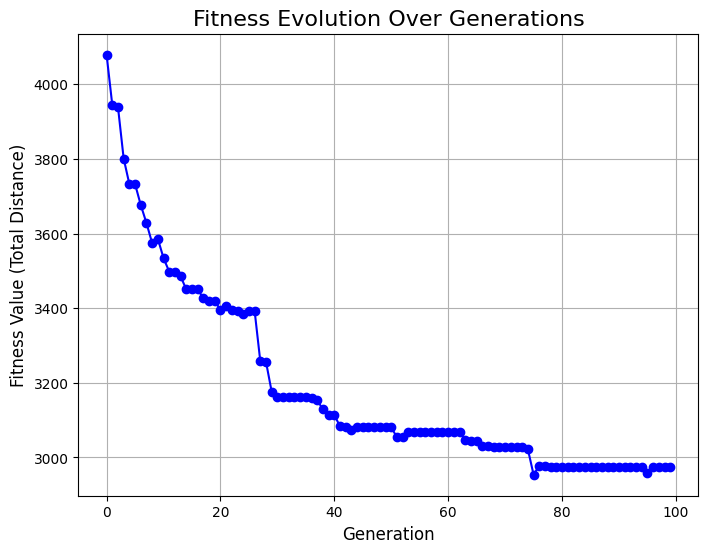

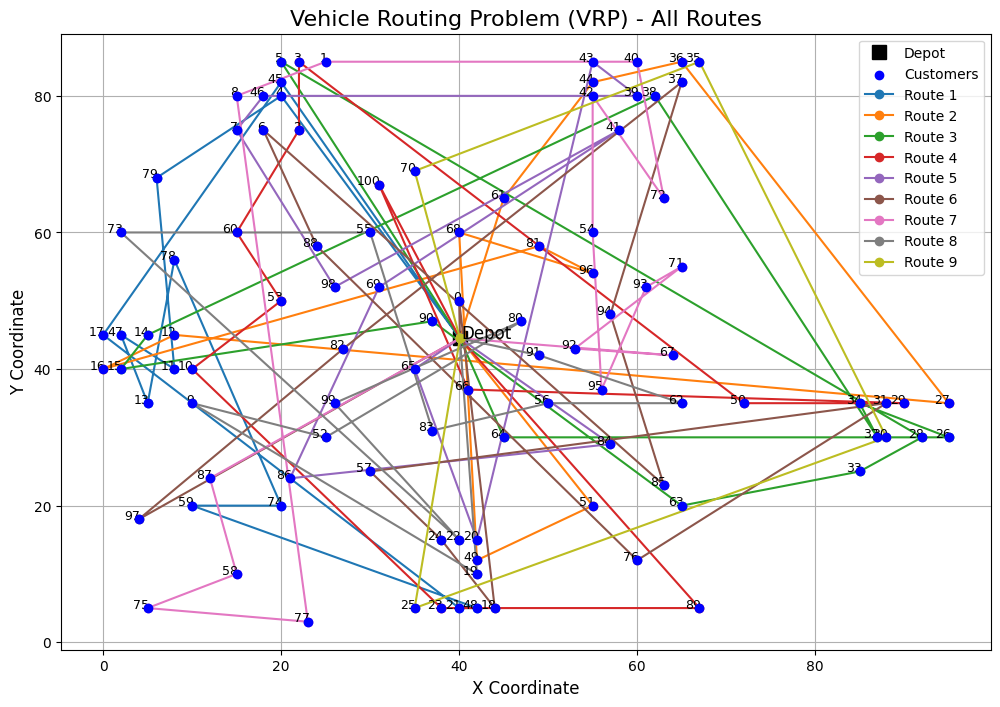

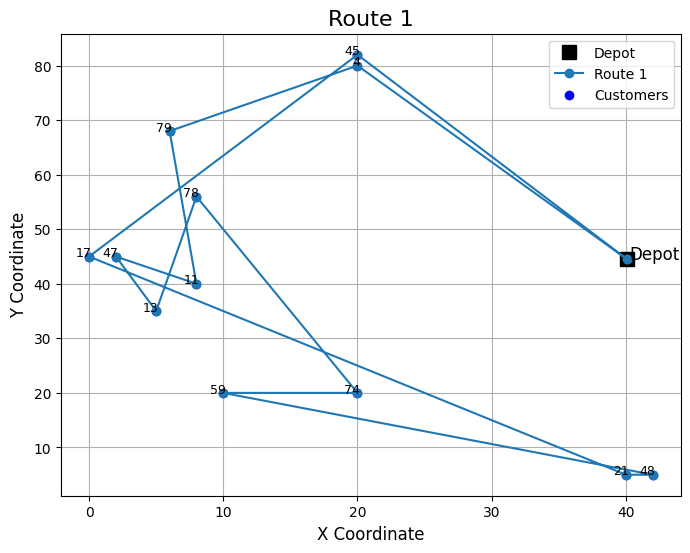

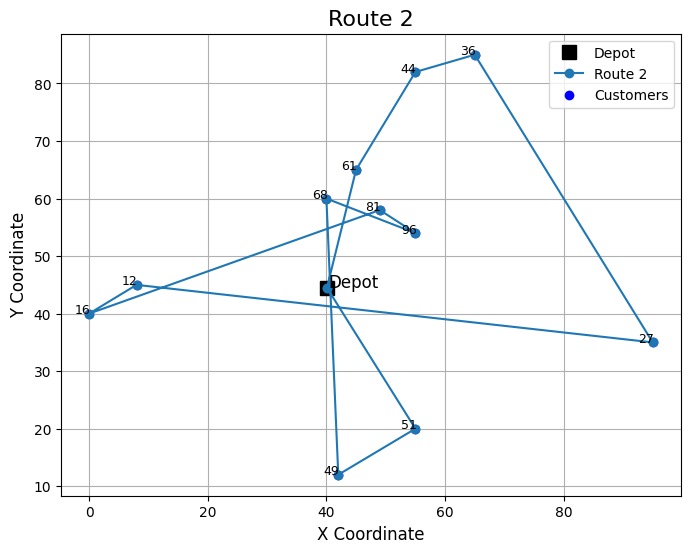

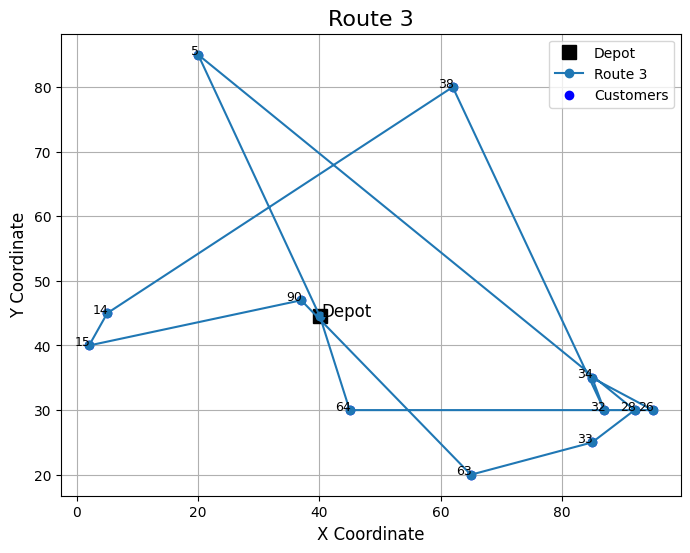

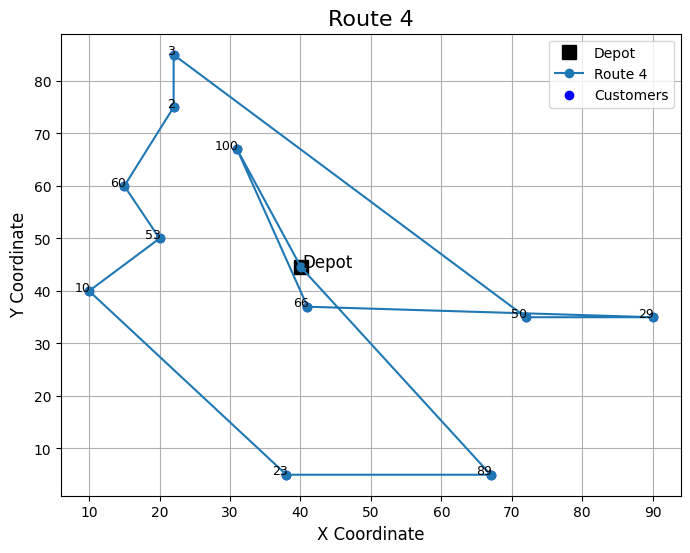

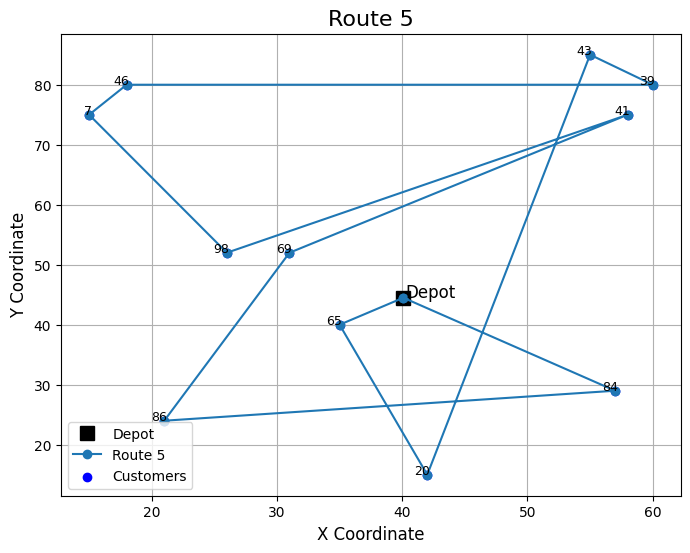

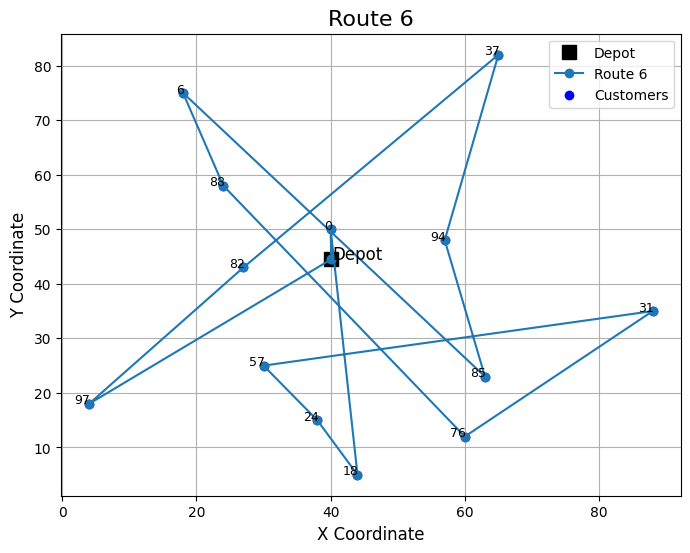

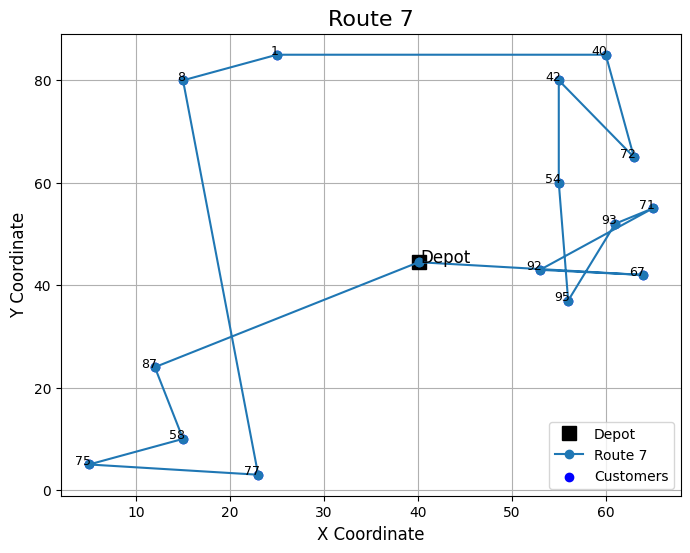

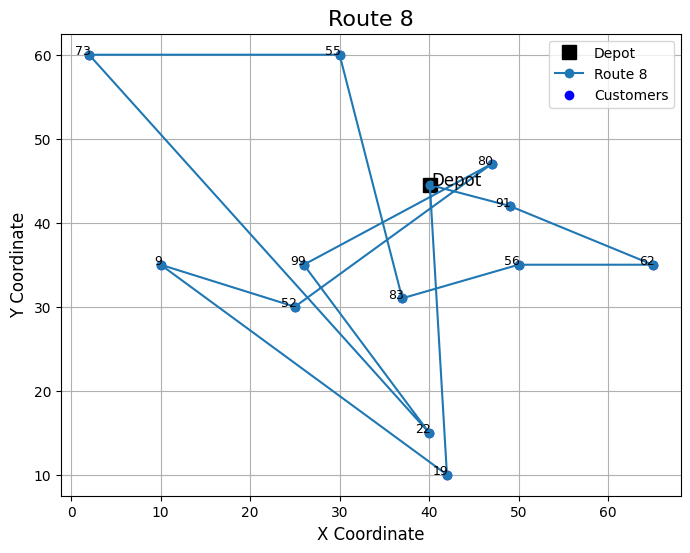

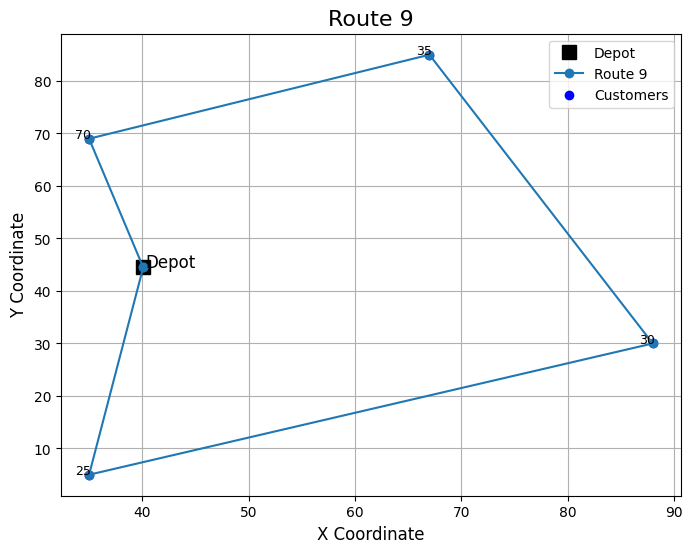

Pop: 20, Gen: 50, Mut: 0.01 => Fitness: 3558.551392098609
Pop: 20, Gen: 50, Mut: 0.05 => Fitness: 3423.6078827366177
Pop: 20, Gen: 50, Mut: 0.1 => Fitness: 3182.3556847412888
Pop: 20, Gen: 100, Mut: 0.01 => Fitness: 3281.132390669509
Pop: 20, Gen: 100, Mut: 0.05 => Fitness: 3443.597104910266
Pop: 20, Gen: 100, Mut: 0.1 => Fitness: 3115.52376500588
Pop: 20, Gen: 200, Mut: 0.01 => Fitness: 3294.134512317259
Pop: 20, Gen: 200, Mut: 0.05 => Fitness: 3016.844019456298
Pop: 20, Gen: 200, Mut: 0.1 => Fitness: 2610.938775421593
Pop: 50, Gen: 50, Mut: 0.01 => Fitness: 3400.5627323956187
Pop: 50, Gen: 50, Mut: 0.05 => Fitness: 3110.509759999231
Pop: 50, Gen: 50, Mut: 0.1 => Fitness: 3000.3971638980097
Pop: 50, Gen: 100, Mut: 0.01 => Fitness: 3185.303637785041
Pop: 50, Gen: 100, Mut: 0.05 => Fitness: 2759.4532476768213
Pop: 50, Gen: 100, Mut: 0.1 => Fitness: 2507.662792220022
Pop: 50, Gen: 200, Mut: 0.01 => Fitness: 3198.2369724905952
Pop: 50, Gen: 200, Mut: 0.05 => Fitness: 2613.56577044779
Pop:

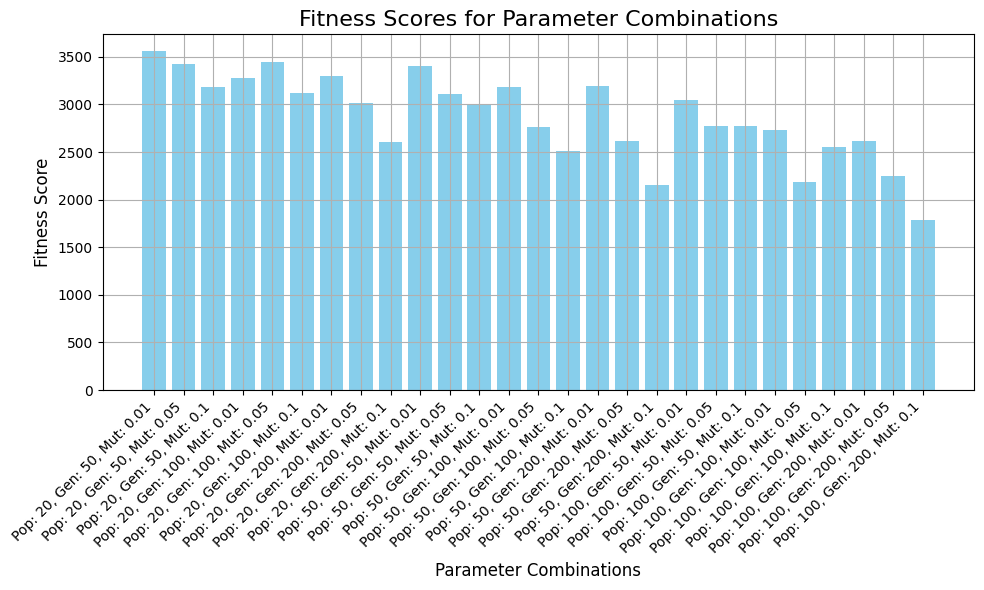

In [ ]:
# Replace the fixed depot coordinates with the calculated center
def solve_vrptw_with_centered_depot(file_path):
    vehicle_capacity, customers = parse_input(file_path)
    num_customers = len(customers)

    # Calculate the depot location as the center of customers
    depot_x, depot_y = calculate_depot_center(customers)
    depot = (depot_x, depot_y)

    dist_matrix = np.zeros((num_customers, num_customers))
    for i in range(num_customers):
        for j in range(num_customers):
            dist_matrix[i][j] = calculate_travel_time(customers[i], customers[j])

    population_size = 50
    generations = 100
    mutation_rate = 0.01
    population = generate_initial_population(population_size, num_customers)
    
    fitness_history = []
    evolved_vehicles_count = []

    for gen in range(generations):
        new_population = []
        for _ in range(population_size // 2):
            parent1, parent2 = select_parents(population, dist_matrix, vehicle_capacity, customers)
            child1 = crossover(parent1, parent2)
            child2 = crossover(parent2, parent1)
            new_population.append(mutate(child1, mutation_rate))
            new_population.append(mutate(child2, mutation_rate))
        population = new_population

        best_individual = min(population, key=lambda x: fitness(x, dist_matrix, vehicle_capacity, customers))
        fitness_history.append(fitness(best_individual, dist_matrix, vehicle_capacity, customers))
        routes = extract_routes(best_individual, customers, vehicle_capacity)
        num_vehicles = len(routes)
        evolved_vehicles_count.append(num_vehicles)

    best_individual = min(population, key=lambda x: fitness(x, dist_matrix, vehicle_capacity, customers))
    routes = extract_routes(best_individual, customers, vehicle_capacity)

    # Plot the results with the depot in the center
    plot_routes(customers, routes, depot=depot)
    plot_individual_routes(customers, routes, depot=depot)



In [ ]:
def solve_vrptw_with_statistics(file_path):
    # Parse input file and calculate depot location
    vehicle_capacity, customers = parse_input(file_path)
    num_customers = len(customers)

    # Calculate depot location as the center of customer locations
    depot_x, depot_y = calculate_depot_center(customers)
    depot = (depot_x, depot_y)

    # Create distance matrix
    dist_matrix = np.zeros((num_customers, num_customers))
    for i in range(num_customers):
        for j in range(num_customers):
            dist_matrix[i][j] = calculate_travel_time(customers[i], customers[j])

    # Genetic algorithm parameters
    population_size = 50
    generations = 100
    mutation_rate = 0.01
    population = generate_initial_population(population_size, num_customers)

    fitness_history = []
    evolved_vehicles_count = []

    # Run genetic algorithm
    for gen in range(generations):
        new_population = []
        for _ in range(population_size // 2):
            parent1, parent2 = select_parents(population, dist_matrix, vehicle_capacity, customers)
            child1 = crossover(parent1, parent2)
            child2 = crossover(parent2, parent1)
            new_population.append(mutate(child1, mutation_rate))
            new_population.append(mutate(child2, mutation_rate))
        population = new_population

        # Track the best individual
        best_individual = min(population, key=lambda x: fitness(x, dist_matrix, vehicle_capacity, customers))
        fitness_history.append(fitness(best_individual, dist_matrix, vehicle_capacity, customers))
        routes = extract_routes(best_individual, customers, vehicle_capacity)
        evolved_vehicles_count.append(len(routes))

        print(f"Generation {gen + 1}, Best Fitness: {fitness_history[-1]}")

    # Final results
    best_individual = min(population, key=lambda x: fitness(x, dist_matrix, vehicle_capacity, customers))
    routes = extract_routes(best_individual, customers, vehicle_capacity)

    print("\nOptimized Routes:")
    for i, route in enumerate(routes):
        print(f"Vehicle {i + 1}: {route}")

    # Statistical visualizations
    plot_fitness_evolution(fitness_history)

    # Plot route visualizations with depot at the center
    plot_routes(customers, routes, depot=depot)
    plot_individual_routes(customers, routes, depot=depot)

In [ ]:

def evaluate_parameter_combinations(file_path):
    # Parse input file and calculate depot location
    vehicle_capacity, customers = parse_input(file_path)
    num_customers = len(customers)

    # Calculate depot location as the center of customer locations
    depot_x, depot_y = calculate_depot_center(customers)
    depot = (depot_x, depot_y)

    # Create distance matrix
    dist_matrix = np.zeros((num_customers, num_customers))
    for i in range(num_customers):
        for j in range(num_customers):
            dist_matrix[i][j] = calculate_travel_time(customers[i], customers[j])

    # Parameter combinations
    population_sizes = [20, 50, 100]
    generations_list = [50, 100, 200]
    mutation_rates = [0.01, 0.05, 0.1]

    best_combination = None
    best_fitness = float('inf')
    results = []

    # Evaluate all combinations
    for population_size in population_sizes:
        for generations in generations_list:
            for mutation_rate in mutation_rates:
                population = generate_initial_population(population_size, num_customers)

                for gen in range(generations):
                    new_population = []
                    for _ in range(population_size // 2):
                        parent1, parent2 = select_parents(population, dist_matrix, vehicle_capacity, customers)
                        child1 = crossover(parent1, parent2)
                        child2 = crossover(parent2, parent1)
                        new_population.append(mutate(child1, mutation_rate))
                        new_population.append(mutate(child2, mutation_rate))
                    population = new_population

                best_individual = min(population, key=lambda x: fitness(x, dist_matrix, vehicle_capacity, customers))
                best_individual_fitness = fitness(best_individual, dist_matrix, vehicle_capacity, customers)

                # Record the results
                results.append({
                    'population_size': population_size,
                    'generations': generations,
                    'mutation_rate': mutation_rate,
                    'fitness': best_individual_fitness
                })

                print(f"Pop: {population_size}, Gen: {generations}, Mut: {mutation_rate} => Fitness: {best_individual_fitness}")

                # Update the best combination
                if best_individual_fitness < best_fitness:
                    best_fitness = best_individual_fitness
                    best_combination = {
                        'population_size': population_size,
                        'generations': generations,
                        'mutation_rate': mutation_rate
                    }

    print("\nBest Parameter Combination:")
    print(f"Population Size: {best_combination['population_size']}, "
          f"Generations: {best_combination['generations']}, "
          f"Mutation Rate: {best_combination['mutation_rate']}, "
          f"Fitness: {best_fitness}")

    # Plot results
    fitness_scores = [result['fitness'] for result in results]
    combinations = [f"Pop: {res['population_size']}, Gen: {res['generations']}, Mut: {res['mutation_rate']}" for res in results]

    plt.figure(figsize=(10, 6))
    plt.bar(combinations, fitness_scores, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.title('Fitness Scores for Parameter Combinations', fontsize=16)
    plt.xlabel('Parameter Combinations', fontsize=12)
    plt.ylabel('Fitness Score', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
if __name__ == "__main__":
    root = tk.Tk()
    root.withdraw()
    file_path = "rc1/rc101.txt"
    if file_path:
        solve_vrptw_with_statistics(file_path)
        evaluate_parameter_combinations(file_path)